Copied and modified from https://github.com/openai/openai-cookbook/blob/010e24382c22fd3edb4f887b2c2d7639baffcc1b/examples/multimodal/Using_GPT4_Vision_With_Function_Calling.ipynb.

# How to use GPT-4 Vision with Function Calling 

The new GPT-4 Turbo model, available as gpt-4-turbo-2024-04-09 as of April 2024, now enables function calling with vision capabilities, better reasoning and a knowledge cutoff date of Dec 2023. Using images with function calling will unlock multimodal use cases and the ability to use reasoning, allowing you to go beyond OCR and image descriptions.

We will go through two examples to demonstrate the use of function calling with GPT-4 Turbo with Vision:

1. Simulating a customer service assistant for delivery exception support
2. Analyzing an organizational chart to extract employee information

### Installation and Setup

In [1]:
%pip install pymupdf --quiet
%pip install openai --quiet
%pip install matplotlib --quiet
# instructor makes it easy to work with function calling
%pip install instructor --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import base64
import os
from enum import Enum
from io import BytesIO
from typing import Iterable
from typing import List
from typing import Literal, Optional

import fitz
# Instructor is powered by Pydantic, which is powered by type hints. Schema validation, prompting is controlled by type annotations
import instructor
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from PIL import Image
from openai import OpenAI
from pydantic import BaseModel, Field

## 1. Simulating a customer service assistant for delivery exception support
We will simulate a customer service assistant for a delivery service that is equipped to analyze images of packages. The assistant will perform the following actions based on the image analysis:
- If a package appears damaged in the image, automatically process a refund according to policy.
- If the package looks wet, initiate a replacement.
- If the package appears normal and not damaged, escalate to an agent.

Let's look at the sample images of packages that the customer service assistant will analyze to determine the appropriate action. We will encode the images as base64 strings for processing by the model.

Encoded image: normal_package.jpg
Encoded image: wet_package.jpg
Encoded image: damaged_package.jpg


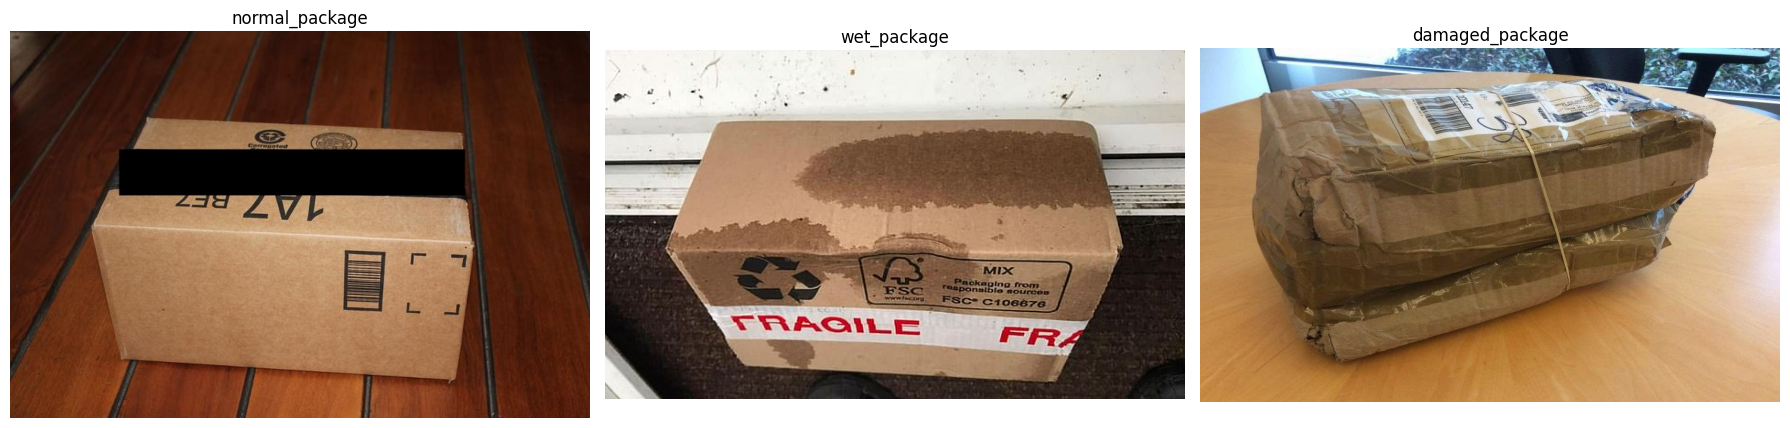

In [3]:
# Function to encode the image as base64
def encode_image(image_path: str):
    # check if the image exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


# Sample images for testing
image_dir = "images"

# encode all images within the directory
image_files = os.listdir(image_dir)
image_data = {}
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    # encode the image with key as the image file name
    image_data[image_file.split('.')[0]] = encode_image(image_path)
    print(f"Encoded image: {image_file}")


def display_images(image_data: dict):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for i, (key, value) in enumerate(image_data.items()):
        img = Image.open(BytesIO(base64.b64decode(value)))
        ax = axs[i]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(key)
    plt.tight_layout()
    plt.show()


display_images(image_data)

We have successfully encoded the sample images as base64 strings and displayed them. The customer service assistant will analyze these images to determine the appropriate action based on the package condition.

Let's now define the functions/tools for order processing, such as escalating an order to an agent, refunding an order, and replacing an order. We will create placeholder functions to simulate the processing of these actions based on the identified tools. We will be using Pydantic models to define the structure of the data for order actions.


In [4]:
# MODEL = "gpt-4-turbo-2024-04-09"
MODEL = "HuggingFaceTB/SmolVLM-Instruct"

class Order(BaseModel):
    """Represents an order with details such as order ID, customer name, product name, price, status, and delivery date."""
    order_id: str = Field(..., description="The unique identifier of the order")
    product_name: str = Field(..., description="The name of the product")
    price: float = Field(..., description="The price of the product")
    status: str = Field(..., description="The status of the order")
    delivery_date: str = Field(..., description="The delivery date of the order")
# Placeholder functions for order processing

def get_order_details(order_id):
    # Placeholder function to retrieve order details based on the order ID
    return Order(
        order_id=order_id,
        product_name="Product X",
        price=100.0,
        status="Delivered",
        delivery_date="2024-04-10",
    )

def escalate_to_agent(order: Order, message: str):
    # Placeholder function to escalate the order to a human agent
    return f"Order {order.order_id} has been escalated to an agent with message: `{message}`"

def refund_order(order: Order):
    # Placeholder function to process a refund for the order
    return f"Order {order.order_id} has been refunded successfully."

def replace_order(order: Order):
    # Placeholder function to replace the order with a new one
    return f"Order {order.order_id} has been replaced with a new order."

class FunctionCallBase(BaseModel):
    rationale: Optional[str] = Field(..., description="The reason for the action.")
    image_description: Optional[str] = Field(
        ..., description="The detailed description of the package image."
    )
    action: Literal["escalate_to_agent", "replace_order", "refund_order"]
    message: Optional[str] = Field(
        ...,
        description="The message to be escalated to the agent if action is escalate_to_agent",
    )
    # Placeholder functions to process the action based on the order ID
    def __call__(self, order_id):
        order: Order = get_order_details(order_id=order_id)
        if self.action == "escalate_to_agent":
            return escalate_to_agent(order, self.message)
        if self.action == "replace_order":
            return replace_order(order)
        if self.action == "refund_order":
            return refund_order(order)

class EscalateToAgent(FunctionCallBase):
    """Escalate to an agent for further assistance."""
    pass

class OrderActionBase(FunctionCallBase):
    pass

class ReplaceOrder(OrderActionBase):
    """Tool call to replace an order."""
    pass

class RefundOrder(OrderActionBase):
    """Tool call to refund an order."""
    pass

### Simulating user messages and processing the package images

We will simulate user messages containing the package images and process the images using the GPT-4 Turbo with Vision model. The model will identify the appropriate tool call based on the image analysis and the predefined actions for damaged, wet, or normal packages. We will then process the identified action based on the order ID and display the results.

In [5]:
# extract the tool call from the response
ORDER_ID = "12345"  # Placeholder order ID for testing
INSTRUCTION_PROMPT = "You are a customer service assistant for a delivery service, equipped to analyze images of packages. If a package appears damaged in the image, automatically process a refund according to policy. If the package looks wet, initiate a replacement. If the package appears normal and not damaged, escalate to agent. For any other issues or unclear images, escalate to agent. You must always use tools!"

def delivery_exception_support_handler(test_image: str):
    payload = {
        "model": MODEL,
        "response_model": Iterable[RefundOrder | ReplaceOrder | EscalateToAgent],
        "tool_choice": "auto",  # automatically select the tool based on the context
        "temperature": 0.0,  # for less diversity in responses
        "seed": 123,  # Set a seed for reproducibility
    }
    payload["messages"] = [
        {
            "role": "user",
            "content": INSTRUCTION_PROMPT,
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_data[test_image]}"
                    }
                },
            ],
        }
    ]
    function_calls = instructor.from_openai(
        # OpenAI(), mode=instructor.Mode.PARALLEL_TOOLS
        OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as an env var>"), base_url="http://localhost:8000/v1"), mode=instructor.Mode.PARALLEL_TOOLS
    ).chat.completions.create(**payload)
    for tool in function_calls:
        print(f"- Tool call: {tool.action} for provided img: {test_image}")
        print(f"- Parameters: {tool}")
        print(f">> Action result: {tool(ORDER_ID)}")
        return tool


print("Processing delivery exception support for different package images...")

print("\n===================== Simulating user message 1 =====================")
assert delivery_exception_support_handler("damaged_package").action == "refund_order"

print("\n===================== Simulating user message 2 =====================")
assert delivery_exception_support_handler("normal_package").action == "escalate_to_agent"

print("\n===================== Simulating user message 3 =====================")
assert delivery_exception_support_handler("wet_package").action == "replace_order"

Processing delivery exception support for different package images...

===================== Simulating user message 1 =====================


TypeError: 'NoneType' object is not iterable

## 2.  Analyzing an organizational chart to extract employee information

For the second example, we will analyze an organizational chart image to extract employee information, such as employee names, roles, managers, and manager roles. We will use GPT-4 Turbo with Vision to process the organizational chart image and extract structured data about the employees in the organization. Indeed, function calling lets us go beyond OCR to actually deduce and translate hierarchical relationships within the chart.

We will start with a sample organizational chart in PDF format that we want to analyze and convert the first page of the PDF to a JPEG image for analysis.

In [ ]:
# Function to convert a single page PDF page to a JPEG image
def convert_pdf_page_to_jpg(pdf_path: str, output_path: str, page_number=0):
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"PDF file not found: {pdf_path}")
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)  # 0 is the first page
    pix = page.get_pixmap()
    # Save the pixmap as a JPEG
    pix.save(output_path)


def display_img_local(image_path: str):
    img = Image.open(image_path)
    display(img)


pdf_path = 'data/org-chart-sample.pdf'
output_path = 'org-chart-sample.jpg'

convert_pdf_page_to_jpg(pdf_path, output_path)
display_img_local(output_path)

The organizational chart image has been successfully extracted from the PDF file and displayed. Let's now define a function to analyze the organizational chart image using the new GPT4 Turbo with Vision. The function will extract information about the employees, their roles, and their managers from the image. We will use function/tool calling to specify the input parameters for the organizational structure, such as the employee name, role, and manager's name and role. We will use Pydantic models to define the structure of the data.


In [49]:
base64_img = encode_image(output_path)

class RoleEnum(str, Enum):
    """Defines possible roles within an organization."""
    CEO = "CEO"
    CTO = "CTO"
    CFO = "CFO"
    COO = "COO"
    EMPLOYEE = "Employee"
    MANAGER = "Manager"
    INTERN = "Intern"
    OTHER = "Other"

class Employee(BaseModel):
    """Represents an employee, including their name, role, and optional manager information."""
    employee_name: str = Field(..., description="The name of the employee")
    role: RoleEnum = Field(..., description="The role of the employee")
    manager_name: Optional[str] = Field(None, description="The manager's name, if applicable")
    manager_role: Optional[RoleEnum] = Field(None, description="The manager's role, if applicable")


class EmployeeList(BaseModel):
    """A list of employees within the organizational structure."""
    employees: List[Employee] = Field(..., description="A list of employees")

def parse_orgchart(base64_img: str) -> EmployeeList:
    response = instructor.from_openai(OpenAI()).chat.completions.create(
        model='gpt-4-turbo',
        response_model=EmployeeList,
        messages=[
            {
                "role": "user",
                "content": 'Analyze the given organizational chart and very carefully extract the information.',
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_img}"
                        }
                    },
                ],
            }
        ],
    )
    return response

Now, we will define a function to parse the response from GPT-4 Turbo with Vision and extract the employee data. We will tabulate the extracted data for easy visualization. Please note that the accuracy of the extracted data may vary based on the complexity and clarity of the input image.

In [ ]:
# call the functions to analyze the organizational chart and parse the response
result = parse_orgchart(base64_img)

# tabulate the extracted data
df = pd.DataFrame([{
    'employee_name': employee.employee_name,
    'role': employee.role.value,
    'manager_name': employee.manager_name,
    'manager_role': employee.manager_role.value if employee.manager_role else None
} for employee in result.employees])

display(df)

The extracted data from the organizational chart has been successfully parsed and displayed in a DataFrame. This approach allows us to leverage GPT-4 Turbo with Vision capabilities to extract structured information from images, such as organizational charts and diagrams, and process the data for further analysis. By using function calling, we can extend the functionality of multimodal models to perform specific tasks or call external functions.